In [286]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_score, precision_recall_curve,
                             roc_curve, recall_score, classification_report, f1_score,
                             average_precision_score)

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from IPython.display import clear_output

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
%matplotlib inline

In [5]:
random_seed = 123
LABELS = ['Normal', 'Fraud']

In [6]:
df = pd.read_csv('creditcard.csv')

In [7]:
df.isnull().values.any()

False

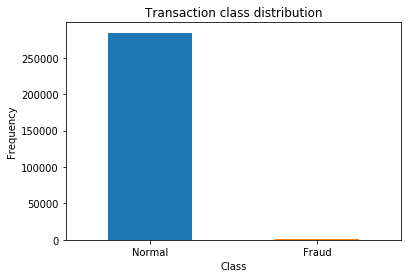

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [232]:
count_classes

0    284315
1       492
Name: Class, dtype: int64

In [10]:
data = df.drop(['Time'], axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [164]:
normal_data = data[data.Class == 0]
anomaly_data = data[data.Class == 1]

X_train, X_val_test = train_test_split(normal_data, test_size=0.3, random_state=241, shuffle=True)
X_val, X_test_norm = train_test_split(X_val_test, test_size=0.3, random_state=241, shuffle=True)
X_train = X_train.drop(['Class'], axis = 1)
y_val = X_val.Class
X_val = X_val.drop(['Class'], axis = 1)

X_test = pd.concat([X_test_norm, anomaly_data])
X_test = X_test.sample(frac=1).reset_index(drop=True)
y_test = X_test.Class
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

print(X_test.shape)

(26081, 29)


In [165]:
pd.value_counts(y_test, sort = True)

0    25589
1      492
Name: Class, dtype: int64

In [166]:
def generator(data, batch_size):
    i = 0
    while True:
        if i + batch_size <= len(data):
            yield data[i:i+batch_size]
            i += batch_size
        else:
            i = 0
            continue

# Baseline

In [380]:
from sklearn.ensemble import IsolationForest

f = IsolationForest()
f.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [385]:
scores = f.decision_function(X_val)
threshold = np.mean(scores) - 2.3 * np.std(scores)

In [386]:
y_pred = (f.decision_function(X_test) < threshold).astype(int)

print 'Precision: {:.3f}'.format(precision_score(y_pred=y_pred, y_true=y_test))
print 'Recall: {:.3f}'.format(recall_score(y_pred=y_pred, y_true=y_test))
print 'F1: {:.3f}'.format(f1_score(y_pred=y_pred, y_true=y_test))

Precision: 0.311
Recall: 0.805
F1: 0.449


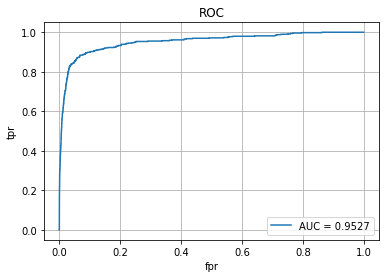

In [243]:
fpr, tpr, thresholds = roc_curve(y_test, 1 - f.decision_function(X_test))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.grid()
plt.legend(loc='lower right')
plt.title('ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

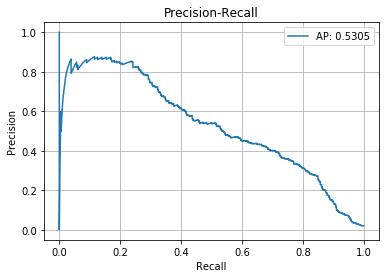

In [391]:
precision, recall, th = precision_recall_curve(y_test, 1 - f.decision_function(X_test))
ap = average_precision_score(y_test, 1 - f.decision_function(X_test))
plt.plot(recall, precision, label='AP: {:.4f}'.format(ap))
plt.grid()
plt.title('Precision-Recall')
plt.legend(loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Autoencoders

In [244]:
def add_noise(x, mean, std):
    noise = Variable(x.data.new(x.size()).normal_(mean, std))
    return x + noise

In [301]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoder_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.encoder_dim = encoder_dim
        self.hidden_dim = hidden_dim
        self.encoder = self.encode()
        self.decoder = self.decode()
        
    def encode(self):
        encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.encoder_dim),
            nn.BatchNorm1d(self.encoder_dim),
            nn.ReLU(),
            nn.Linear(self.encoder_dim, int(self.encoder_dim / 2)),
            nn.BatchNorm1d(int(self.encoder_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(self.encoder_dim / 2), int(self.encoder_dim / 4)))
        return encoder
    
    def decode(self):
        decoder = nn.Sequential(
            nn.Linear(self.hidden_dim, int(self.encoder_dim / 2)),
            nn.BatchNorm1d(int(self.encoder_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(self.encoder_dim / 2), self.encoder_dim),
            nn.BatchNorm1d(self.encoder_dim),
            nn.ReLU(),
            nn.Linear(self.encoder_dim, self.input_dim),
            nn.BatchNorm1d(self.input_dim),
            nn.Tanh())
        return decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [308]:
class DenAutoencoder(Autoencoder):
    def __init__(self, input_dim, encoder_dim, hidden_dim, mean=0, std=0.05):
        super(DenAutoencoder, self).__init__(input_dim, encoder_dim, hidden_dim)
        self.mean = mean 
        self.std = std
    
    def forward(self, x):
        if self.training:
            x = add_noise(x, self.mean, self.std)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [316]:
class VAE(Autoencoder):
    def __init__(self, input_dim, encoder_dim, hidden_dim):
        super(VAE, self).__init__(input_dim, encoder_dim, hidden_dim)
        self._enc_mu = torch.nn.Linear(5, hidden_dim)
        self._enc_log_sigma = torch.nn.Linear(5, hidden_dim)

    def _sample_latent(self, h_enc):
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 0.01, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

In [302]:
batchsize = 512
train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]
train_gen = generator(X_train, batchsize)
val_gen = generator(X_val, batchsize)
test_gen = generator(X_test, 1)

In [303]:
from tqdm import trange

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    num_iter = int(float(train_size) / float(batchsize))
    for i in range(num_iter):
        x_batch = train_gen.next()
        data = Variable(torch.from_numpy(x_batch).float())
        target = Variable(torch.from_numpy(x_batch).float())
        optimizer.zero_grad()
        output = model(data)   
        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log

def test(model, batchsize=32):
    loss_log = []
    model.eval()
    num_iter = int(float(val_size) / float(batchsize))
    for i in range(num_iter): 
        x_batch = val_gen.next()
        data = Variable(torch.from_numpy(x_batch).float())
        target = Variable(torch.from_numpy(x_batch).float())
        output = model(data)
        loss = F.mse_loss(output, target)
        
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title=' Average loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.plot(val_history, label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_l, val_l = [], []
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batchsize)

        val_loss = test(model, batchsize)
        
        if epoch > -1:
            train_l.extend(train_loss)
            train_log.append(np.mean(train_l))
            val_l.extend(val_loss)
            val_log.append(np.mean(val_l))
        
            clear_output()
            plot_history(train_log, val_log)    
            print 'Epoch {}, average loss: {:.4f}'.format(epoch + 1, np.mean(train_log)) 
    print 'Best validation loss: {:.4f}'.format(val_log[-1])

def predict(model, data):
    model.eval()
    predictions = []
    for i in range(test_size): 
        x_batch = test_gen.next()
        data = Variable(torch.from_numpy(x_batch).float())
        output = model(data)
        predictions.append(output.data.numpy())
    print('Done')
    return predictions

In [304]:
torch.manual_seed(123)
input_dim = X_train.shape[1]
encoder_dim = 20
hidden_dim = int(encoder_dim / 4)

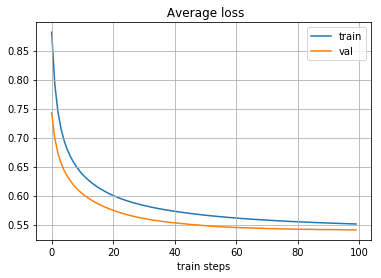

Epoch 100, average loss: 0.5856
Best validation loss: 0.5409
CPU times: user 9min 58s, sys: 18.2 s, total: 10min 16s
Wall time: 1min 37s


In [305]:
%%time

model1 = Autoencoder(input_dim, encoder_dim, hidden_dim)
opt1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-3)
train(model1, opt1, 100)

In [306]:
predictions1 = predict(model1, X_test)

Done


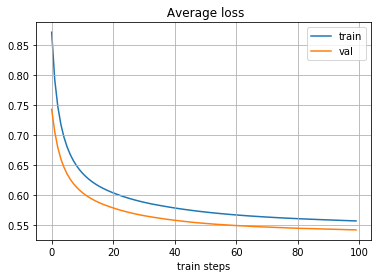

Epoch 100, average loss: 0.5902
Best validation loss: 0.5423


In [311]:
model2 = DenAutoencoder(input_dim, encoder_dim, hidden_dim)
opt2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-3)
train(model2, opt2, 100)

In [312]:
predictions2 = predict(model2, X_test)

Done


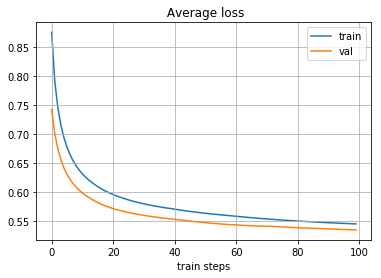

Epoch 100, average loss: 0.5823
Best validation loss: 0.5355
CPU times: user 11min 57s, sys: 18.2 s, total: 12min 15s
Wall time: 1min 55s


In [317]:
%%time
latent_dim = 8
vae = VAE(input_dim, encoder_dim, latent_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-3)
train(vae, optimizer, 100)

In [318]:
predictions3 = predict(vae, X_test)

Done


In [319]:
predictions1 = np.squeeze(np.array(predictions1))
predictions2 = np.squeeze(np.array(predictions2))
predictions3 = np.squeeze(np.array(predictions3))
print(np.array(predictions1).shape, X_test.shape)

((26081, 29), (26081, 29))


In [320]:
mse = np.mean(np.power(X_test - predictions1, 2), axis=1)
error_df1 = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df1.describe()

,reconstruction_error,true_class
count,26081.000000,26081.000000
mean,1.057774,0.018864
std,13.480235,0.136048
min,0.030503,0.000000
25%,0.127918,0.000000
50%,0.215929,0.000000
75%,0.418368,0.000000
max,1849.234779,1.000000


In [321]:
mse = np.mean(np.power(X_test - predictions2, 2), axis=1)
error_df2 = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df2.describe()

,reconstruction_error,true_class
count,26081.000000,26081.000000
mean,1.043848,0.018864
std,13.429646,0.136048
min,0.014977,0.000000
25%,0.113952,0.000000
50%,0.194459,0.000000
75%,0.396166,0.000000
max,1844.140354,1.000000


In [322]:
mse = np.mean(np.power(X_test - predictions3, 2), axis=1)
error_df3 = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df3.describe()

,reconstruction_error,true_class
count,26081.000000,26081.000000
mean,1.040001,0.018864
std,13.440434,0.136048
min,0.016220,0.000000
25%,0.106849,0.000000
50%,0.195514,0.000000
75%,0.401384,0.000000
max,1843.552019,1.000000


In [433]:
error_df = error_df3

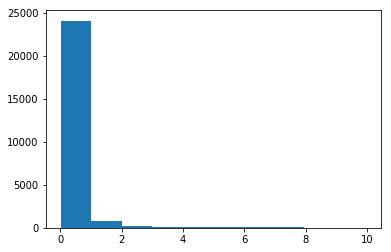

In [340]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

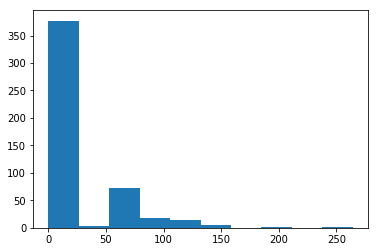

In [341]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

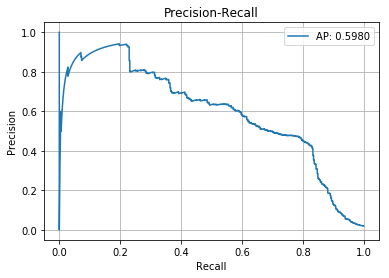

In [434]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
ap = average_precision_score(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, label='AP: {:.4f}'.format(ap))
plt.grid()
plt.title('Precision-Recall')
plt.legend(loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

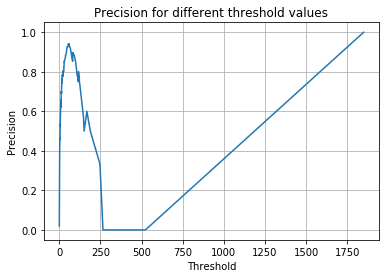

In [396]:
plt.plot(th, precision[1:], label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

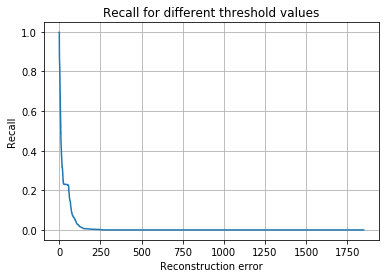

In [397]:
plt.plot(th, recall[1:], label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.grid()
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

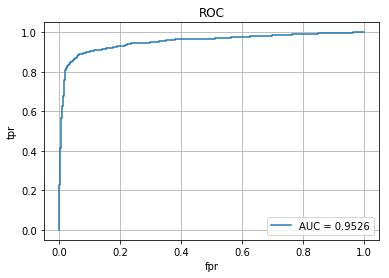

In [421]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.grid()
plt.legend(loc='lower right')
plt.title('ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [435]:
groups = error_df.groupby('true_class')

d = []
for name, group in groups:
    if name == 0:
        d.append(group.reconstruction_error)
print(np.mean(d) + 0.2*np.std(d))

3.007056995523228


In [438]:
threshold = 3.3

In [439]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

print 'Precision: {:.4f}'.format(precision_score(error_df.true_class, y_pred))
print 'Recall: {:.4f}'.format(recall_score(error_df.true_class, y_pred))
print 'F1: {:.4f}'.format(f1_score(error_df.true_class, y_pred))

Precision: 0.4513
Recall: 0.8008
F1: 0.5773


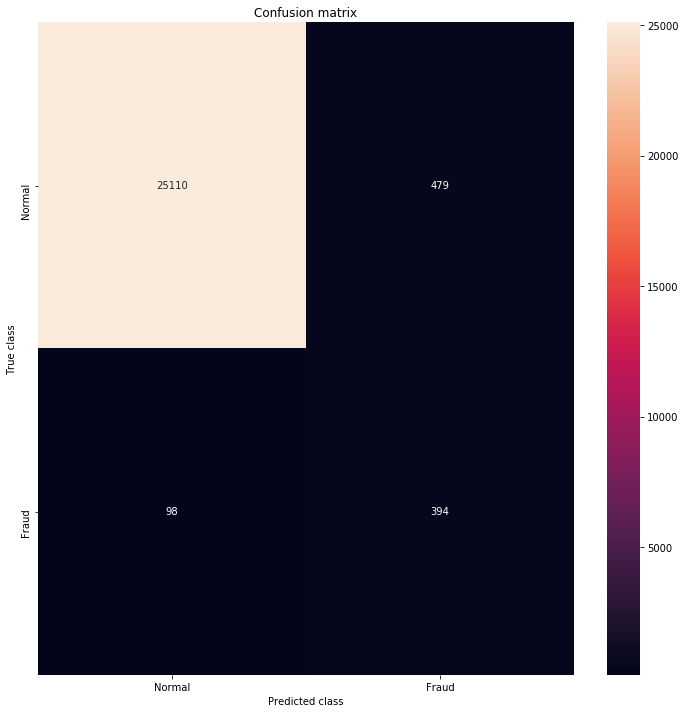

In [440]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()